In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [31]:
# Load benchmark data from CSV files
cpu_benchmark_data = pd.read_csv('cpu_benchmark_results.csv')
gpu_benchmark_data = pd.read_csv('gpu_benchmark_result.csv')
qe_tsm_benchmark_data = pd.read_csv('qe_tsm_benchmark_results.csv')

In [32]:
qe_tsm_benchmark_data.head()

,Run,N,CUDA-Q Target,Shots,Population,T,Trotter Steps,Best E,Q Sample Time,MTS Conv. Time,Total Time,Merit F.,Generations,Sequence
0,1,1,NaN,1000,100,1.0,3,0,0.113932,0.000000,0.114208,NaN,0,+
1,1,2,NaN,1000,100,1.0,3,1,0.002079,0.000000,0.138033,2.00,1000,++
2,1,3,NaN,1000,100,1.0,3,1,0.002629,0.000000,0.167960,4.50,1000,-++
3,1,4,NaN,1000,100,1.0,3,2,0.005243,0.000000,0.213247,4.00,1000,-+++
4,1,5,NaN,1000,100,1.0,3,2,0.005440,0.000421,0.267534,6.25,1000,+-+++


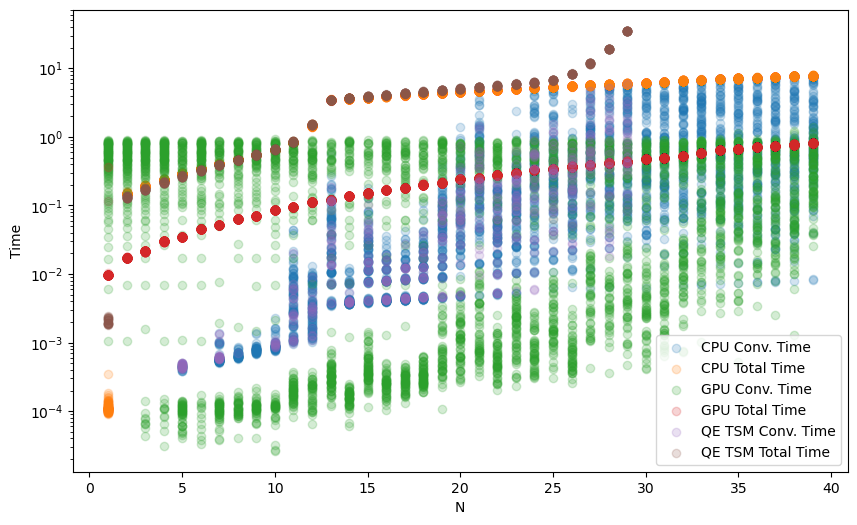

In [ ]:
# plot the median convergence time and total time for each N
plt.figure(figsize=(10, 6))
plt.scatter(cpu_benchmark_data['N'], cpu_benchmark_data['Conv. Time'], label='CPU Conv. Time', alpha=0.2)
plt.scatter(cpu_benchmark_data['N'], cpu_benchmark_data['Total Time'], label='CPU Total Time', alpha=0.2)
plt.scatter(gpu_benchmark_data['N'], gpu_benchmark_data['Conv. Time'], label='GPU Conv. Time', alpha=0.2)
plt.scatter(gpu_benchmark_data['N'], gpu_benchmark_data['Total Time'], label='GPU Total Time', alpha=0.2)
plt.scatter(qe_tsm_benchmark_data['N'], qe_tsm_benchmark_data['MTS Conv. Time'], label='QE MTS Conv. Time', alpha=0.2)
plt.scatter(qe_tsm_benchmark_data['N'], qe_tsm_benchmark_data['Total Time'], label='QE MTS Total Time', alpha=0.2)
plt.xlabel('N')
plt.ylabel('Time')
plt.yscale('log')
plt.legend()
plt.show()

In [36]:
# find median convergence time and total time for each N
cpu_median_conv_time = cpu_benchmark_data.groupby('N')['Conv. Time'].median()
gpu_median_conv_time = gpu_benchmark_data.groupby('N')['Conv. Time'].median()
qe_tsm_median_conv_time = qe_tsm_benchmark_data.groupby('N')['MTS Conv. Time'].median()

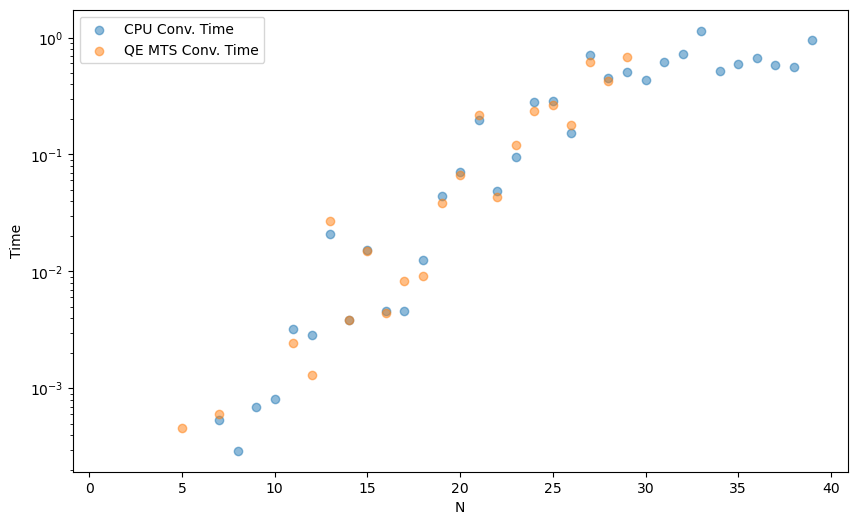

In [40]:
# plot the median convergence time and total time for each N
plt.figure(figsize=(10, 6))
plt.scatter(cpu_median_conv_time.index, cpu_median_conv_time, label='CPU Conv. Time', alpha=0.5)
# plt.scatter(gpu_median_conv_time.index, gpu_median_conv_time, label='GPU Conv. Time', alpha=0.5)
plt.scatter(qe_tsm_median_conv_time.index, qe_tsm_median_conv_time, label='QE MTS Conv. Time', alpha=0.5)
plt.xlabel('N')
plt.ylabel('Time')
plt.yscale('log')
plt.legend()
plt.show()

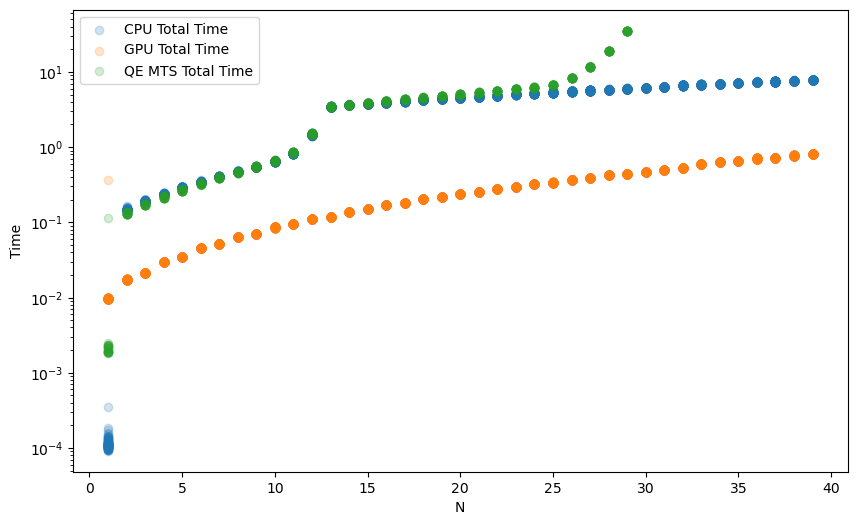

In [42]:
# plot all total time for each N
plt.figure(figsize=(10, 6))
plt.scatter(cpu_benchmark_data['N'], cpu_benchmark_data['Total Time'], label='CPU Total Time', alpha=0.2)
plt.scatter(gpu_benchmark_data['N'], gpu_benchmark_data['Total Time'], label='GPU Total Time', alpha=0.2)
plt.scatter(qe_tsm_benchmark_data['N'], qe_tsm_benchmark_data['Total Time'], label='QE MTS Total Time', alpha=0.2)
plt.xlabel('N')
plt.ylabel('Time')
plt.yscale('log')
plt.legend()
plt.show()

a=0.000343704  alpha=1.25454  R^2 (log-space)=0.6568  n=2127


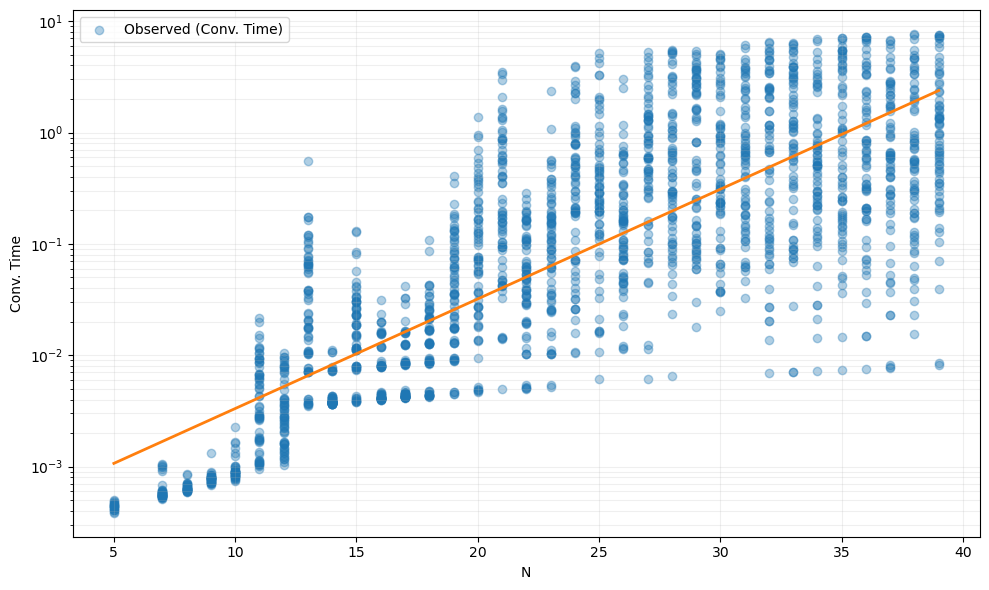

In [30]:
# create regression plot for convergence time ~ N. should be time = a * alpha^N
import numpy as np
import matplotlib.pyplot as plt

# For each N, select the minimum 'Conv. Time' across all runs
N = benchmark_data['N']
conv_time = benchmark_data['Conv. Time']

# Fit exponential regression: time = a * alpha^N
# Taking logs gives: log(time) = log(a) + N * log(alpha)

def fit_exponential(N, conv_time):
    N = np.asarray(N, dtype=float)
    conv_time = np.asarray(conv_time, dtype=float)

    mask = np.isfinite(N) & np.isfinite(conv_time) & (conv_time > 0)
    if mask.sum() < 2:
        return np.nan, np.nan, np.nan, mask

    x = N[mask]
    y = conv_time[mask]
    logy = np.log(y)

    A = np.vstack([np.ones_like(x), x]).T
    b0, b1 = np.linalg.lstsq(A, logy, rcond=None)[0]

    a = float(np.exp(b0))
    alpha = float(np.exp(b1))

    logy_hat = b0 + b1 * x
    ss_res = float(np.sum((logy - logy_hat) ** 2))
    ss_tot = float(np.sum((logy - np.mean(logy)) ** 2))
    r2_log = (1.0 - ss_res / ss_tot) if ss_tot > 0 else np.nan

    return a, alpha, r2_log, mask


a, alpha, r2_log, mask = fit_exponential(N, conv_time)
print(f"a={a:.6g}  alpha={alpha:.6g}  R^2 (log-space)={r2_log:.4f}  n={int(mask.sum())}")

x = np.asarray(N, dtype=float)[mask]
y = np.asarray(conv_time, dtype=float)[mask]

order = np.argsort(x)
x_sorted = x[order]
y_fit = a * (alpha ** x_sorted)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.35, label='Observed (Conv. Time)')
plt.plot(x_sorted, y_fit, color='C1', linewidth=2)
plt.xlabel('N')
plt.ylabel('Conv. Time')
plt.yscale('log')
plt.grid(True, which='both', alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()
